In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2024-01-03 14:38:25.199859: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  

In [3]:
from koopmanlib.dictionary import PsiNN
from koopmanlib.target import VanderPolOscillator

In [4]:
basis_function = PsiNN(layer_sizes=[200,200,200], n_psi_train=40)

In [5]:
# Generate data
vdp_train = VanderPolOscillator()
data_x_train = vdp_train.generate_init_data(n_traj=1000, traj_len=10, seed=0)
data_y_train = vdp_train.generate_next_data(data_x_train)

vdp_valid = VanderPolOscillator()
data_x_valid = vdp_valid.generate_init_data(n_traj=300, traj_len=10, seed=0)
data_y_valid = vdp_valid.generate_next_data(data_x_valid)

2024-01-03 14:38:28.212888: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-03 14:38:28.675174: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9645 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1c:00.0, compute capability: 7.5


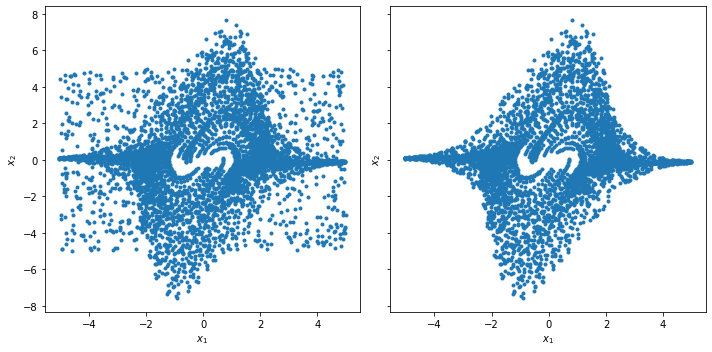

In [6]:
# Visualize data
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=(10,5))

ax1.plot(data_x_train[:,0], data_x_train[:,1], '.')
ax1.set_xlabel(r'$x_{1}$')
ax1.set_ylabel(r'$x_{2}$')
ax2.plot(data_y_train[:,0], data_y_train[:,1], '.')
ax2.set_xlabel(r'$x_{1}$')
ax2.set_ylabel(r'$x_{2}$')
plt.tight_layout()

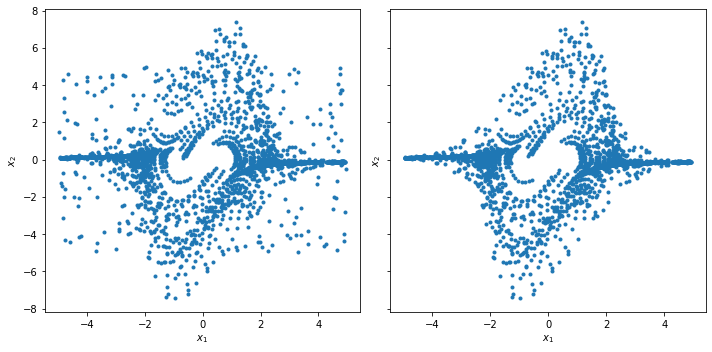

In [7]:
# Visualize data
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=(10,5))

ax1.plot(data_x_valid[:,0], data_x_valid[:,1], '.')
ax1.set_xlabel(r'$x_{1}$')
ax1.set_ylabel(r'$x_{2}$')
ax2.plot(data_y_valid[:,0], data_y_valid[:,1], '.')
ax2.set_xlabel(r'$x_{1}$')
ax2.set_ylabel(r'$x_{2}$')
plt.tight_layout()

In [8]:
data_train = [data_x_train, data_y_train]
data_valid = [data_x_valid, data_y_valid]

In [9]:
from koopmanlib.solver import KoopmanDLSolver
solver = KoopmanDLSolver(dic=basis_function,
                         target_dim=2,
                         reg=0.1)

In [10]:
solver.build(data_train=data_train,
             data_valid=data_valid,
             epochs=2000,
             batch_size=5000,
             lr=1e-4,
             log_interval=20,
             lr_decay_factor=0.8)

Epoch 1/2


2024-01-03 14:38:32.324557: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x5628a060b950


2/2 [==============================] - 1s 224ms/step - loss: 0.2121 - val_loss: 0.1474
Epoch 2/2
2/2 [==============================] - 0s 75ms/step - loss: 0.2394 - val_loss: 0.0700
number of the outer loop: 0
Epoch 1/2
2/2 [==============================] - 0s 81ms/step - loss: 0.0364 - val_loss: 0.1034
Epoch 2/2
2/2 [==============================] - 0s 57ms/step - loss: 0.0755 - val_loss: 0.0180
number of the outer loop: 1
Epoch 1/2
2/2 [==============================] - 0s 77ms/step - loss: 0.0189 - val_loss: 0.0622
Epoch 2/2
2/2 [==============================] - 0s 65ms/step - loss: 0.0485 - val_loss: 6.9399e-04
number of the outer loop: 2
Epoch 1/2
2/2 [==============================] - 0s 86ms/step - loss: 0.0107 - val_loss: 0.0385
Epoch 2/2
2/2 [==============================] - 0s 61ms/step - loss: 0.0312 - val_loss: 8.0440e-04
number of the outer loop: 3
Epoch 1/2
2/2 [==============================] - 0s 82ms/step - loss: 0.0063 - val_loss: 0.0226
Epoch 2/2
2/2 [==========

In [11]:
solver.compute_final_info(reg_final=0.0)

# Prediction

In [12]:
traj_len = 50

In [13]:
from koopmanlib.dictionary import DicRBF
from koopmanlib.solver import KoopmanGeneralSolver

In [14]:
rbf_basis_func = DicRBF(rbf_number=100, regularizer=1e-4)
rbf_basis_func.build(data_x_train)

rbf_solver = KoopmanGeneralSolver(dic=rbf_basis_func,
                                  target_dim=2,
                                  reg=0.0)

rbf_solver.build(data_train)

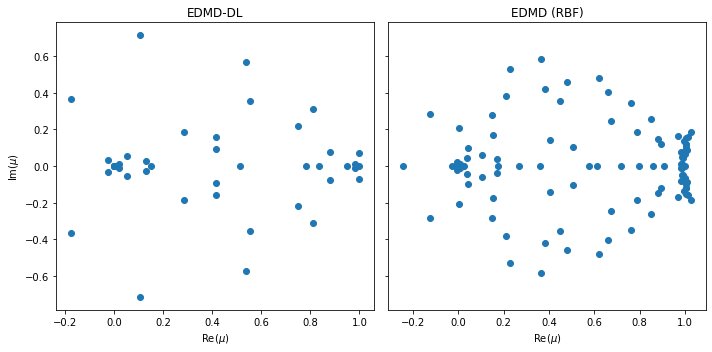

In [15]:
# Plot eigenvalues
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=True)
ax1.scatter(solver.eigenvalues.real,solver.eigenvalues.imag)
ax1.set_xlabel(r'Re$(\mu)$')
ax1.set_ylabel(r'Im$(\mu)$')
ax1.set_title('EDMD-DL')

# Plot eigenvalues
ax2.scatter(rbf_solver.eigenvalues.real, rbf_solver.eigenvalues.imag)
ax2.set_xlabel(r'Re$(\mu)$')
ax2.set_title('EDMD (RBF)')

fig.tight_layout()
# plt.cla()
# plt.clf()
# plt.close()

In [16]:
# Plot reconstruction
import matplotlib
matplotlib.rcParams.update({'font.size': 18})

# Generate testing data
vdp_test = VanderPolOscillator()
data_x_test = vdp_test.generate_init_data(n_traj=1, traj_len=traj_len, seed=123)
data_y_test = vdp_test.generate_next_data(data_x_test)

# Exact trajectory
x_traj = data_x_test

# Estimated trajectory from DL
x0_test = data_x_test[0]
x0_test = x0_test.reshape(-1,x0_test.shape[-1])

In [17]:
x_est_traj_DL = solver.predict(x0_test, traj_len)
x_est_traj_rbf = rbf_solver.predict(x0_test, traj_len)

In [18]:
# Calcualte errors
DL_error = np.sqrt( np.mean(np.square(x_est_traj_DL-x_traj)) ) 
rbf_error = np.sqrt( np.mean(np.square(x_est_traj_rbf-x_traj)) ) 

DL error:  0.016368937700167254   RBF error:  0.025141255513470035


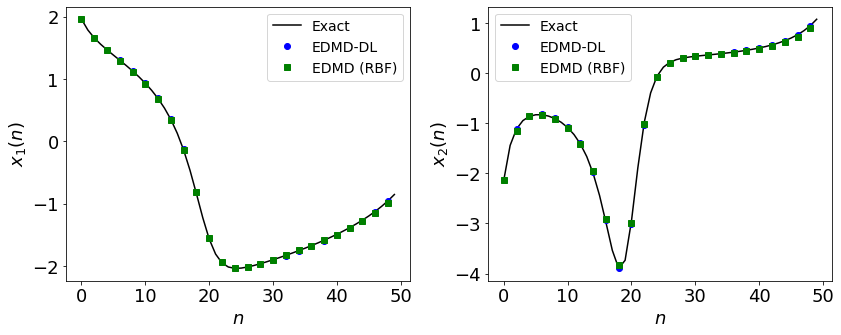

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(12,5))  

# Plot
t_grid = np.arange(0,traj_len)
ax1.plot(t_grid, x_traj[:,0], 'k-', label='Exact', markevery=2)
ax1.plot(t_grid, x_est_traj_DL[:,0], 'bo', label='EDMD-DL', markevery=2)
ax1.plot(t_grid, x_est_traj_rbf[:,0], 'gs', label='EDMD (RBF)', markevery=2)
    
ax2.plot(t_grid, x_traj[:,1], 'k-', label='Exact', markevery=2)
ax2.plot(t_grid, x_est_traj_DL[:,1], 'bo', label='EDMD-DL', markevery=2)
ax2.plot(t_grid, x_est_traj_rbf[:,1], 'gs', label='EDMD (RBF)', markevery=2)


ax1.set_xlabel(r"$n$")
ax1.set_ylabel(r"$x_{1}(n)$")
ax1.legend(loc='best',prop={'size':14})

ax2.set_xlabel(r"$n$")
ax2.set_ylabel(r"$x_{2}(n)$")
ax2.legend(loc='best',prop={'size':14})

print ("DL error: ", DL_error,
      "  RBF error: ", rbf_error)
fig.tight_layout()

In [20]:
# Generate dynamical data
xmin, xmax = vdp_test.x_min, vdp_test.x_max
dim = vdp_test.dim

# Check eigenfunction quality
ds = 0.2
num_print = 8

x_grid = (np.mgrid[xmin:xmax+ds:ds, xmin:xmax+ds:ds].reshape(dim,-1).T)

ode_solver = vdp_test.euler

# DL
phi_DL = solver.eigenfunctions(x_grid)
phif_DL = solver.eigenfunctions(ode_solver(x_grid))
mu_DL = solver.eigenvalues
error_DL = np.mean(((phi_DL*mu_DL)-phif_DL)**2 , axis=0)
print("DL Eigenfunction errors:\n", np.abs(error_DL)[0:8])


# rbf
phi_rbf = rbf_solver.eigenfunctions(x_grid)
phif_rbf = rbf_solver.eigenfunctions(ode_solver(x_grid))
mu_rbf = rbf_solver.eigenvalues
error_rbf = np.mean( ((phi_rbf*mu_rbf)-phif_rbf)**2 , axis=0)
print("rbf Eigenfunction errors:\n", np.abs(error_rbf)[0:8])

DL Eigenfunction errors:
 [8.27558096e-18 8.18193777e-09 8.18193777e-09 1.97801885e-08
 1.97801885e-08 1.88528970e-08 4.41445788e-09 4.41445788e-09]
rbf Eigenfunction errors:
 [2.04354268e-07 2.04354268e-07 1.97499593e-07 1.97499593e-07
 6.84239969e-06 6.84239969e-06 1.17345911e-07 1.17345911e-07]


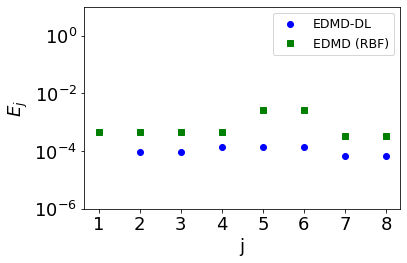

In [21]:
ax = plt.axes()
plt.semilogy(np.sqrt(np.abs(error_DL)[0:8]), "bo", label="EDMD-DL")
plt.semilogy(np.sqrt(np.abs(error_rbf[0:8])), "gs", label="EDMD (RBF)")
plt.legend(loc="best", fontsize='x-small')
ax.set_xticks(np.arange(8))
ax.set_xticklabels(np.arange(1, 9))
ax.set_xlabel("j")
ax.set_ylabel(r"$E_j$")
ax.set_ylim([1e-6, 1e1])
plt.tight_layout()
# plt.cla()
# plt.clf()
# plt.close()

In [22]:
# Number of outputs vs reconstruction accuracy
dic_dims = [0, 1, 5, 10, 25, 50, 100]

# Train Koopman model with different number of dictionaries
dl_solvers = []

for d in dic_dims:
    basis_function = PsiNN(layer_sizes=[100,100,100], n_psi_train=d)
    solver = KoopmanDLSolver(dic=basis_function,
                         target_dim=2,
                         reg=0.1)
    solver.build(data_train=data_train,
              data_valid=data_valid,
              epochs=500,
              batch_size=5000,
              lr=1e-4,
              log_interval=20,
              lr_decay_factor=0.8)

    dl_solvers.append(solver)
    print ("Model has %d trainable parameters." % d)

n_test = 50
dl_errors = []
traj_len = 50 # length of test trajectories

for i in range(len(dl_solvers)):
    solver = dl_solvers[i]
    dl_error = 0 
    for j in range(n_test):
        if j%10 == 0:
            print("Model no.: ", i, " Test no.: ", j)
        # Generate testing data
        vdp_test = VanderPolOscillator()
        data_x_test = vdp_test.generate_init_data(n_traj=1, traj_len=traj_len, seed=100)

        # Exact trajectory
        x_traj = data_x_test

        # Estimated trajectory from DL
        x0_test = data_x_test[0]
        x0_test = x0_test.reshape(-1,x0_test.shape[-1])
        x_est_traj_DL = solver.predict(x0_test, traj_len)

        # Calcualte errors
        dl_error += np.sqrt(np.mean(np.abs(np.square(x_est_traj_DL-x_traj))))
    dl_errors.append(dl_error/n_test)

Epoch 1/2
2/2 [==============================] - 1s 140ms/step - loss: 0.1397 - val_loss: 0.1429
Epoch 2/2
2/2 [==============================] - 0s 37ms/step - loss: 0.1397 - val_loss: 0.1429
number of the outer loop: 0
Epoch 1/2
2/2 [==============================] - 0s 60ms/step - loss: 0.1397 - val_loss: 0.1429
Epoch 2/2
2/2 [==============================] - 0s 35ms/step - loss: 0.1397 - val_loss: 0.1429
number of the outer loop: 1
Epoch 1/2
2/2 [==============================] - 0s 55ms/step - loss: 0.1397 - val_loss: 0.1429
Epoch 2/2
2/2 [==============================] - 0s 38ms/step - loss: 0.1397 - val_loss: 0.1429
number of the outer loop: 2
Epoch 1/2
2/2 [==============================] - 0s 63ms/step - loss: 0.1397 - val_loss: 0.1429
Epoch 2/2
2/2 [==============================] - 0s 35ms/step - loss: 0.1397 - val_loss: 0.1429
number of the outer loop: 3
Epoch 1/2
2/2 [==============================] - 0s 56ms/step - loss: 0.1397 - val_loss: 0.1429
Epoch 2/2
2/2 [========

In [23]:
rbf_dic_dims = [1, 5, 10, 25, 50, 100]

rbf_solvers = []
for d in rbf_dic_dims:
    rbf_basis_func = DicRBF(rbf_number=d, regularizer=1e-4)
    rbf_basis_func.build(data_x_train)
    rbf_solver = KoopmanGeneralSolver(dic=rbf_basis_func,
                                      target_dim=2,
                                      reg=0.0)
    rbf_solver.build(data_train)
    rbf_solvers.append(rbf_solver)

n_test = 50
rbf_errors = []
traj_len = 50 # length of test trajectories

for i in range(len(rbf_solvers)):
    solver = rbf_solvers[i]
    rbf_error = 0 
    for j in range(n_test):
        if j%10 == 0:
            print("Model no.: ", i, " Test no.: ", j)
        # Generate testing data
        vdp_test = VanderPolOscillator()
        data_x_test = vdp_test.generate_init_data(n_traj=1, traj_len=traj_len, seed=100)

        # Exact trajectory
        x_traj = data_x_test

        # Estimated trajectory from rbf
        x0_test = data_x_test[0]
        x0_test = x0_test.reshape(-1,x0_test.shape[-1])
        x_est_traj_rbf = solver.predict(x0_test, traj_len)

        # Calcualte errors
        rbf_error += np.sqrt(np.mean(np.square(x_est_traj_rbf-x_traj)))
    rbf_errors.append(rbf_error/n_test)
rbf_errors = [dl_errors[0]]+rbf_errors

ddims = [0, 1, 5, 10, 25, 50, 100]

Model no.:  0  Test no.:  0


Model no.:  0  Test no.:  10
Model no.:  0  Test no.:  20
Model no.:  0  Test no.:  30
Model no.:  0  Test no.:  40
Model no.:  1  Test no.:  0
Model no.:  1  Test no.:  10
Model no.:  1  Test no.:  20
Model no.:  1  Test no.:  30
Model no.:  1  Test no.:  40
Model no.:  2  Test no.:  0
Model no.:  2  Test no.:  10
Model no.:  2  Test no.:  20
Model no.:  2  Test no.:  30
Model no.:  2  Test no.:  40
Model no.:  3  Test no.:  0
Model no.:  3  Test no.:  10
Model no.:  3  Test no.:  20
Model no.:  3  Test no.:  30
Model no.:  3  Test no.:  40
Model no.:  4  Test no.:  0
Model no.:  4  Test no.:  10
Model no.:  4  Test no.:  20
Model no.:  4  Test no.:  30
Model no.:  4  Test no.:  40
Model no.:  5  Test no.:  0
Model no.:  5  Test no.:  10
Model no.:  5  Test no.:  20
Model no.:  5  Test no.:  30
Model no.:  5  Test no.:  40


Text(0.5, 0, 'Number of dictionary elements')

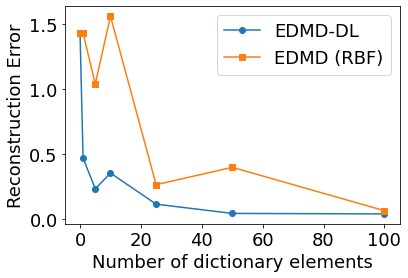

In [24]:
matplotlib.rcParams.update({'font.size': 18})

plt.plot(ddims,dl_errors, "-o", label="EDMD-DL")
plt.plot(ddims,rbf_errors, "-s", label="EDMD (RBF)")
plt.legend(loc="best")
plt.ylabel("Reconstruction Error")
plt.xlabel("Number of dictionary elements")
# plt.clf()